In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA
import pickle
from pathlib import Path
from typing import List, Tuple
import glob

from classification.datasets import Dataset

from classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from classification.utils.utils import accuracy
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [2]:
model_dir = "../goldenProject/python/model2/"
fv_dir = "../goldenProject/python/dataset/"

<font size=5 color=#009999> 1. Our dataset </font> <br>

<font size=4 color=#009999> 1.1 Build matrix of fv </font> <br>

In [3]:
def get_cls_from_path(file):
    return file.stem.split("_", maxsplit=1)[0]


format = "pickle"
classnames = ['birds','chainsaw','fire','handsaw','helicopter']

#fv = pickle.load(open(fv_dir + filename, 'rb'))
#print(fv)
#print(fv.shape)

dic_fv = {}
for file in sorted((Path(fv_dir)).glob("**/*." + format)):
    #print(str(file))
    fv = pickle.load(open(file, 'rb'))
    fv = np.squeeze(fv)
    cls = get_cls_from_path(file)
    #print(cls)
    dic_fv.setdefault(cls, []).append(fv)
print(dic_fv)

nclass = len(dic_fv)
naudio = len(dic_fv[list(dic_fv.keys())[0]])
size = nclass * naudio

print(nclass)
print(naudio)
print(size)

# plt.figure()
# plot_specgram(fv.reshape((20, 20)).T, ax=plt.gca(), is_mel=True, title="MEL Spectrogram", xlabel="Mel vector")
# plt.show()


{'birds': [array([ 40,  24,  10,   4,   3,   6,   6,  14,  14,  11,   5,   6,  16,
        16, 104, 182,  40,  28,  17,  15,  19,  13,   8,   4,   6,   6,
         7,  13,  22,  20,   6,  13,  79,  91, 191, 239,  83,  44,  17,
        12,  28,  24,  10,   4,   8,   9,  16,  13,  14,  13,   4,   8,
        23,  26,  83, 130,  46,  27,  13,   9,  24,  20,   7,   3,   4,
         6,  10,  18,  15,  14,   5,   9,  20,  23, 130, 226,  54,  34,
        13,  10,  28,  18,   9,   5,  16,  17,   7,  16,  22,  18,   6,
        15,  59,  76, 142, 180,  82,  49,  18,  11,  19,  16,   8,   4,
         9,   8,   7,  12,  11,  10,   5,   9,  17,  28,  86, 135,  38,
        41,  19,   9,  40,  15,   9,   4,   3,   9,  12,  14,  20,  23,
         5,   6,  16,  26, 135, 196,  52,  51,  23,  17,  29,  17,   5,
         1,   4,  10,  25,  20,  23,  34,  17,  18,  66,  98, 162, 177,
        69,  46,  26,  38,  22,  15,  13,   9,   5,  17,  14,  20,  14,
        20,  14,  10,  27,  33,  78, 119,  35,  44,  

In [4]:
### Features vectors build matrix ###

train_pct = 0.7
print(len(dic_fv["birds"][0]))
featveclen = len(dic_fv["birds"][0]) # number of items in a feature vector
#nitems = size
nlearn = round(naudio * train_pct) # number of sounds among naudio for training
fm_dir = "data/feature_matrices2/"

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio*data_aug_factor) #matrice avec les noms des classes x le nombre de sons (40 de base)

X = np.zeros((data_aug_factor*size, featveclen)) #nombre de sons total x taille du feature vector
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = dic_fv[classname][idx] #melspec
            X[s*nclass*naudio+class_idx*naudio+idx,:] = featvec       
#np.save(fm_dir+"feature_matrix_2D_Bby.npy", X)


400


In [5]:
#X = np.load(fm_dir+"feature_matrix_2D_Bby.npy")

# "Labels"
y = class_ids_aug.copy() #noms des sons

print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

print()
### Training the simple KNN ###



### Accuracy ###

Shape of the feature matrix : (100, 400)
Number of labels : 100



<font size=4 color=#009999> 1.2 Training/testing our model </font> <br>

Accuracy of KNN with fixed train/validation sets : 40.0%


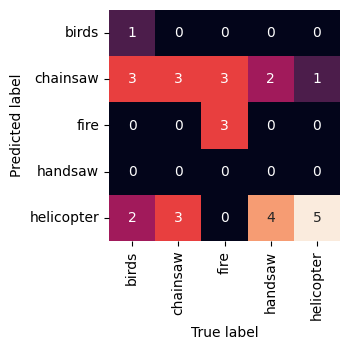

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_train_normalised = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

#-------------------------

K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model.fit(X_train_normalised,y_train)
prediction = model.predict(X_test_normalised)

accuracy_knn = accuracy(prediction , y_test)

filename = 'KNN.pickle'
pickle.dump(model, open(model_dir+filename, 'wb'))

print('Accuracy of KNN with fixed train/validation sets : {:.1f}%'.format(100*accuracy_knn))
show_confusion_matrix (prediction, y_test, classnames)


Accuracy of RFC with fixed train/validation sets : 53.3%


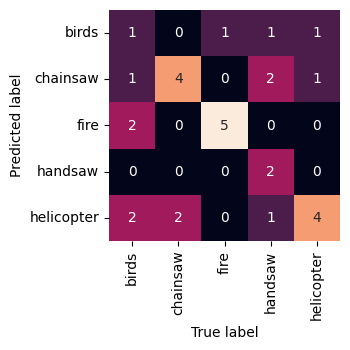

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # random_state=1

# [2] (optional) Data normalization
X_train_normalised = X_train/ np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalised = X_test/ np.linalg.norm(X_test, axis=1, keepdims=True)

# [3] (optional) dimensionality reduction.
...


# [4] Model training and selection.
n_splits = 10
kf = StratifiedKFold(n_splits = n_splits)

model = RFC()
accuracy_RFC = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train_normalised,y_train)):
  (idx_learn, idx_val) = idx
  model.fit(X_train_normalised[idx_learn], y_train[idx_learn])
  prediction = model.predict(X_train_normalised[idx_val])
  accuracy_RFC[k] = accuracy(prediction, y_train[idx_val])

# [5] Save the trained model, eventually the pca.
filename = 'RFC.pickle'
pickle.dump(model, open(model_dir+filename, 'wb'))

# [6] Evaluate the model.
prediction_RFC = model.predict(X_test_normalised)
accuracy_RFC = accuracy(prediction_RFC, y_test)

print('Accuracy of RFC with fixed train/validation sets : {:.1f}%'.format(100*accuracy_RFC))
show_confusion_matrix (prediction_RFC, y_test, classnames)

<font size=5 color=#009999> 2. Basic dataset </font> <br>

In [5]:
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [6]:
fm_dir = "dataNN/feature_ma/" # where to save the features matrices
model_dir = "dataNN/model/" # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [7]:
"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

20

In [13]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire",0]) # number of items in a feature vector
nitems = len(myds) # number of sounds in the dataset
naudio = dataset.naudio # number of audio files in each class
nclass = dataset.nclass # number of classes
nlearn = round(naudio * train_pct) # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio*data_aug_factor)

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X = np.zeros((data_aug_factor*nclass*naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx]
            X[s*nclass*naudio+class_idx*naudio+idx,:] = featvec       
np.save(fm_dir+"feature_matrix_2D.npy", X)

# X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()

print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

Shape of the feature matrix : (200, 400)
Number of labels : 200


<font size=5 color=#009999> Augmentation data </font> <br>

In [62]:
import time

myds.data_aug = None # Ensure
myds.data_aug_factor = 1

### TO RUN
# myds.mod_data_aug(['add_bg'])
# myds.mod_data_aug(['echo'])
# myds.mod_data_aug(['noise'])
# myds.mod_data_aug(['scaling'])

myds.mod_data_aug(['echo','add_bg'])
y_aug = np.repeat(classnames, dataset.naudio*myds.data_aug_factor) # Labels

for i in range (10):
    print(i)
    cls_index = ["birds",i]
    sound = dataset.__getitem__(cls_index) 
    audio = AudioUtil.open(sound)
    AudioUtil.play(audio)
    time.sleep(5)
    

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X_aug = np.zeros((myds.data_aug_factor*nclass*naudio, featveclen))
for s in range(myds.data_aug_factor):
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx]  
            X_aug[s*nclass*naudio+class_idx*naudio+idx,:] = featvec 
np.save(fm_dir+"feature_matrix_2D_aug.npy", X_aug)
print(len(X_aug))
#X_aug = np.load(fm_dir+"feature_matrix_2D_aug.npy")

print('Shape of the feature matrix : {}'.format(X_aug.shape))
print('Number of labels : {}'.format(len(y_aug)))

0
1
2
3
4
5
6
7
8
9
600
Shape of the feature matrix : (600, 400)
Number of labels : 600


Accuracy of KNN with fixed train/validation sets : 10.6%


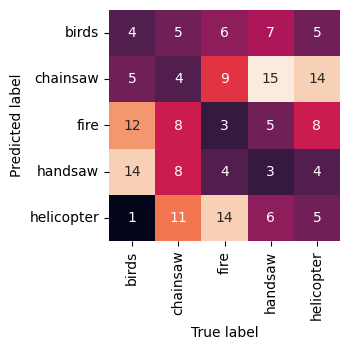

In [55]:
train_pct = 0.7
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, stratify=y_aug)

X_train_normalised = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

#-------------------------

K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model.fit(X_train_normalised,y_train)
prediction = model.predict(X_test_normalised)

accuracy_knn = accuracy(prediction , y_test)

print('Accuracy of KNN with fixed train/validation sets : {:.1f}%'.format(100*accuracy_knn))
show_confusion_matrix (prediction, y_test, classnames)

<font size=5 color=#009999> Simple KNN - jouet </font> <br>

Accuracy of KNN with fixed train/validation sets : 46.7%


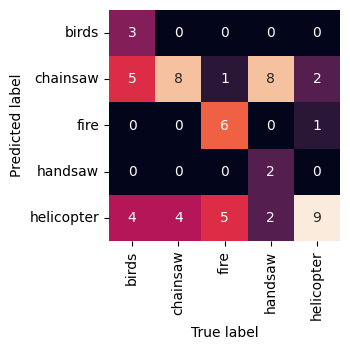

In [9]:
train_pct = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_train_normalised = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

#-------------------------

K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model.fit(X_train_normalised,y_train)
prediction = model.predict(X_test_normalised)

accuracy_knn = accuracy(prediction , y_test)

print('Accuracy of KNN with fixed train/validation sets : {:.1f}%'.format(100*accuracy_knn))
show_confusion_matrix (prediction, y_test, classnames)



Mean accuracy with 5-Fold CV: 41.4%
Std deviation in accuracy with 5-Fold CV: 8.3%


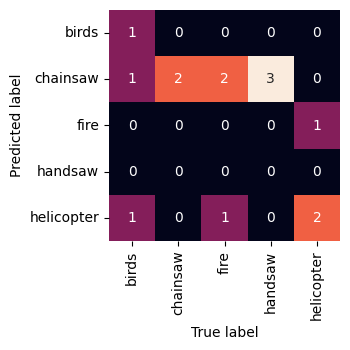

In [10]:
K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

n_splits = 10
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)

accuracy_KNN = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train_normalised,y_train)):
  (idx_train, idx_test) = idx
  model.fit(X_train_normalised[idx_train], y_train[idx_train])
  prediction_KNN = model.predict(X_train_normalised[idx_test])
  accuracy_KNN[k] = accuracy(prediction_KNN, y_train[idx_test])

print('Mean accuracy with 5-Fold CV: {:.1f}%'.format(100*accuracy_KNN.mean()))
print('Std deviation in accuracy with 5-Fold CV: {:.1f}%'.format(100*accuracy_KNN.std()))
show_confusion_matrix(prediction_KNN, y_train[idx_test], classnames)


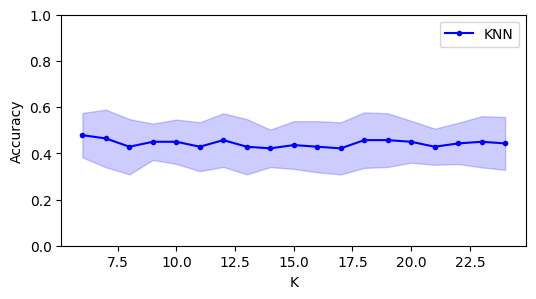

In [11]:
### TO RUN
Ks = np.arange(6,25, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i,K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights='distance') 
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_knn.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_knn = model_knn.predict(X_train[idx_val])
            accuracies_knn[i,k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6,3))
plt.plot(Ks, means_knn, '.-b', label='KNN')
plt.fill_between(Ks,means_knn-stds_knn,means_knn+stds_knn,alpha=0.2,color='b')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Save the trained model, eventually the pca.
#filename = 'model.pickle'
#pickle.dump(model, open(model_dir+filename, 'wb'))